# **Required Downloads**

In [121]:
!pip install -q transformers
!pip install -q contractions
!pip install -q autocorrect

     |████████████████████████████████| 622 kB 13.2 MB/s 


# **Required Imports**

In [130]:

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer,TFRobertaForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import ElectraTokenizer,TFElectraForSequenceClassification
from transformers import GPT2Tokenizer,TFGPT2ForSequenceClassification
from transformers import FlaubertTokenizer,TFFlaubertForSequenceClassification
from transformers import DebertaTokenizer,TFDebertaForSequenceClassification

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

import tensorflow as tf
import json

import numpy as np
import pandas as pd


import os
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

import contractions
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# **Data Prepration**

## Importing Data
- The following cell is importing data from google drive and storing the files to /home/Emotiondata directory.
- Data Source: 
> https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
DataDir = '/home/EmotionData/'
!mkdir /home/EmotionData
!unzip /content/drive/MyDrive/archive.zip 
!mv /content/*.txt /home/EmotionData

mkdir: cannot create directory ‘/home/EmotionData’: File exists
Archive:  /content/drive/MyDrive/archive.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


## Loading Data
- The Following cell loads train, validation and test data to variables 
- Used Sources: 
>https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [171]:
def readDataEmotionData1(dataPath):
  data = pd.read_csv(DataDir+dataPath, sep=";", header=None, names = ['Text','Label'])
  return data;

trainData = readDataEmotionData1('train.txt')
valData = readDataEmotionData1('val.txt')
testData = readDataEmotionData1('test.txt')
# Shows how the data looks in the padas DataFrame after loading 
trainData.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## About the Data


In [172]:
# The following function adds length coloum to pandas Dataframe
def addTextLength(dataFrame):
  lengthData = []
  for i in dataFrame['Text']:
    lengthData.append(len(i))
  dataFrame=dataFrame.assign(Length=lengthData)
  return dataFrame
trainData = addTextLength(trainData)
valData = addTextLength(valData)
testData = addTextLength(testData)
valData.head()

,Text,Label,Length
0,im feeling quite sad and sorry for myself but ...,sadness,69
1,i feel like i am still looking at a blank canv...,sadness,70
2,i feel like a faithful servant,love,30
3,i am just feeling cranky and blue,anger,33
4,i can have for a treat or if i am feeling festive,joy,49


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


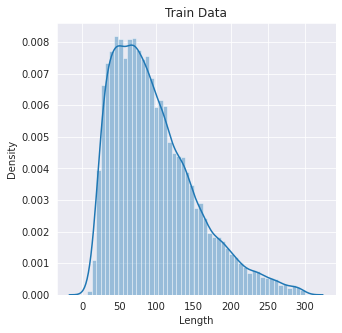

In [173]:
# This shows the distrubution of the number of characters length of the Text.
def plotDestrubrition(data,name):
  sns.set_style('darkgrid')
  plt.figure(figsize=(5,5))
  plt.title(name)
  sns.distplot(data)
plotDestrubrition(trainData['Length'],'Train Data')

In [174]:
trainData.describe()

,Length
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


## Text Prepration
- Decontracted: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
- Spell check
- About Formatted Data
- Labels One hot enconding
- Text Enconding using Model specific, ex. BertTokenizer, RobertaTokenizer,etc.

In [175]:
def Decontracted(DataFrame):
  for i, text in enumerate(DataFrame['Text']):
    DataFrame['Text'][i] = contractions.fix(text)
  return DataFrame
trainData = Decontracted(trainData)
valData = Decontracted(valData)
testData = Decontracted(testData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
from autocorrect import Speller
def SpellCheck(DataFrame):
  spell = Speller(lang='en')
  for i, text in enumerate(DataFrame['Text']):
      DataFrame['Text'][i] = str(spell(text))
  return DataFrame

trainData = SpellCheck(trainData)
valData = SpellCheck(valData)
testData = SpellCheck(testData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [193]:
def LabelEnconding(DataFrame):
  encodeVectorizer = CountVectorizer(analyzer = "word", tokenizer = None,lowercase=True, preprocessor = None, stop_words = None)
  encodedLabels = encodeVectorizer.fit_transform(DataFrame['Label'])
  LabelsNames = encodeVectorizer.get_feature_names()
  return encodedLabels.toarray(),LabelsNames
encodedTrainLabels,TrainLabelFeatureNames = LabelEnconding(trainData)
encodedValLabels,ValLabelFeatureNames = LabelEnconding(valData)
encodedTestLabels,TestLabelFeatureNames = LabelEnconding(testData)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
